# 🚲 London Bike Sharing — Análise Exploratória e Previsão de Séries Temporais


### 📌 Visão Geral do Projeto


Este projeto utiliza o London Bike Sharing Dataset, disponibilizado na plataforma Kaggle, com o objetivo de analisar padrões de uso do sistema de bicicletas compartilhadas da cidade de Londres e aplicar técnicas de ciência de dados e machine learning para previsão de séries temporais.

O conjunto de dados contém registros horários de utilização de bicicletas, integrados a informações temporais e meteorológicas, permitindo uma análise detalhada do comportamento da demanda ao longo do tempo.


### 📊 Sobre o Conjunto de Dados

Cada observação representa um intervalo de uma hora e inclui, entre outras variáveis:

- Quantidade de bicicletas alugadas no período

- Data e hora do registro

- Condições climáticas (temperatura, umidade, velocidade do vento e tipo de clima)

- Indicadores de sazonalidade (estação do ano)

- Flags de fim de semana e feriado

Essa combinação de atributos torna o dataset especialmente adequado para análises temporais, identificação de padrões sazonais e modelagem preditiva baseada em variáveis exógenas


### 🎯 Objetivo do Projeto

Os principais objetivos deste projeto são:

- Realizar Análise Exploratória de Dados (EDA) para identificar tendências, ciclos sazonais e padrões horários de utilização;

- Avaliar a influência de fatores climáticos e temporais sobre a demanda por bicicletas;

- Aplicar técnicas de modelagem de séries temporais e machine learning para prever o número de bicicletas alugadas em períodos futuros;

- Demonstrar, de forma prática, habilidades em pré-processamento de dados, feature engineering, validação de modelos e interpretação de resultados.



Link do desafio: https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_components
import itertools
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [2]:
# Setando o pandas para exibir todas as colunas do data frame
pd.options.display.max_columns = None

# Definir que o Pandas exiba números de ponto flutuante com duas casas decimais
pd.set_option('display.float_format', '{:.2f}'.format)

# Carregando o Dataset

In [3]:
dados = pd.read_csv('bicicletas.csv')
dados.head()

,data_hora,contagem,temperatura,sensacao_termica,umidade,velocidade_vento,clima,feriado,fim_de_semana,estacao
0,2015-01-04 00:00:00,182,3.00,2.00,93.00,6.00,Nublado,Não,Sim,Inverno
1,2015-01-04 01:00:00,138,NaN,NaN,93.00,5.00,Céu limpo,Não,Sim,Inverno
2,2015-01-04 02:00:00,134,2.50,2.50,96.50,0.00,Céu limpo,Não,Sim,Inverno
3,2015-01-04 03:00:00,72,2.00,2.00,100.00,0.00,Céu limpo,Não,Sim,Inverno
4,2015-01-04 04:00:00,47,NaN,NaN,93.00,6.50,Céu limpo,Não,Sim,Inverno


## Informações básicas do conjunto de dados

- `data_hora` - Data e hora do registro     
- `contagem` - contagem de novos compartilhamentos de bicicletas      
- `temperatura` - temperatura real em °C    
- `sensacao_termica` -  temperatura em °C da "sensação térmica"     
- `umidade` - umidade em porcentagem    
- `velocidade_vento` - velocidade do vento em km/h  
- `clima` - categoria do clima (Céu limpo, Parcialmente nublado, Nublado, Chuva leve, Chuva com trovoadas e Neve)     
- `feriado` - "Sim" se for feriado / "Não" se não for feriado      
- `fim_de_semana` - "Sim" se for final de semana / "Não" se não for final de semana     
- `estacao` - campo de categoria estações meteorológicas: primavera, verão, outono e nverno.  

In [4]:
print(f'Dimensões: {dados.shape}')

Dimensões: (17429, 10)


# Análise Exploratória de Dados

In [5]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17429 entries, 0 to 17428
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data_hora         17429 non-null  object 
 1   contagem          17429 non-null  int64  
 2   temperatura       17406 non-null  float64
 3   sensacao_termica  17406 non-null  float64
 4   umidade           17429 non-null  float64
 5   velocidade_vento  17429 non-null  float64
 6   clima             17429 non-null  object 
 7   feriado           17429 non-null  object 
 8   fim_de_semana     17429 non-null  object 
 9   estacao           17429 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.3+ MB


Durante o carregamento dos dados o Pandas identifica e atribui automaticamente os tipos de variáveis aos dados. Contudo, existem casos em que é necessário fazer a conversão do tipo de dados, como, o tipo da variável `data_hora`, a fim de tratar os atributos temporais de forma mais adequada.  

Ainda com base na informação acima, é possível observar que as variáveis `temperatura` e `sensacao_termica` possuem problemas com valores ausentes. Vamos verificar a quantidade de itens faltantes a seguir:

In [6]:
def analyze_missing(df):

    type_var = df.dtypes
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100
    
    result = pd.DataFrame({
        'Type' : type_var,
        'Missing Count': missing_count,
        'Missing %': missing_percent
        
    })
    
    return result

In [7]:
analyze_missing(dados)

,Type,Missing Count,Missing %
data_hora,object,0,0.00
contagem,int64,0,0.00
temperatura,float64,23,0.13
sensacao_termica,float64,23,0.13
umidade,float64,0,0.00
velocidade_vento,float64,0,0.00
clima,object,0,0.00
feriado,object,0,0.00
fim_de_semana,object,0,0.00
estacao,object,0,0.00


## Tratando dados nulos

Acima podemos verifcar que existem 23 valores ausentes, tanto para `temperatura` quanto para `sensacao_termica`. Como a coleta desses dados seguem uma ordem cronológica e, temos posse dos valores antes e depois aos dados faltantes, vamos usar o método de Interpolaçao Linear para fazer preenchimento desses itens. Para isso, vamos usar a função *interpolate()* da biblioteca **Pandas**.

In [8]:
dados['temperatura'] = dados['temperatura'].interpolate(method='linear')
dados['sensacao_termica'] = dados['sensacao_termica'].interpolate(method='linear')

In [9]:
dados.isnull().sum()

data_hora           0
contagem            0
temperatura         0
sensacao_termica    0
umidade             0
velocidade_vento    0
clima               0
feriado             0
fim_de_semana       0
estacao             0
dtype: int64

Pronto, os valores nulos foram tratados de forma adequada.

## Identificando e removendo dados duplicados

In [10]:
dados.duplicated().sum()

np.int64(15)

Com o resultado acima, é sabido que em nosso conjunto de dados temos um total de 15 linhas de dados com informações duplicadas. Abaixo vamos fazer a identificação dessas duplicatas antes da sua remoção.

In [11]:
# Identificar as linhas duplicadas no Dataframe
duplicatas = dados.duplicated(keep=False)

# Selecionar as linhas duplicadas com base na etapa anterior
linhas_duplicadas = dados[duplicatas]

# Ordenando as linhas duplicadas pela coluna "data_hora"
linhas_duplicadas.sort_values(by='data_hora')

,data_hora,contagem,temperatura,sensacao_termica,umidade,velocidade_vento,clima,feriado,fim_de_semana,estacao
519,2015-01-25 16:00:00,1238,8.00,5.00,71.00,18.00,Nublado,Não,Sim,Inverno
17422,2015-01-25 16:00:00,1238,8.00,5.00,71.00,18.00,Nublado,Não,Sim,Inverno
869,2015-02-09 06:00:00,479,5.00,3.50,87.00,6.50,Parcialmente nublado,Não,Não,Inverno
17417,2015-02-09 06:00:00,479,5.00,3.50,87.00,6.50,Parcialmente nublado,Não,Não,Inverno
3655,2015-06-05 18:00:00,3411,23.00,23.00,50.00,26.00,Parcialmente nublado,Não,Não,Verão
17425,2015-06-05 18:00:00,3411,23.00,23.00,50.00,26.00,Parcialmente nublado,Não,Não,Verão
4167,2015-06-27 02:00:00,337,15.50,15.50,74.50,18.00,Parcialmente nublado,Não,Sim,Verão
17421,2015-06-27 02:00:00,337,15.50,15.50,74.50,18.00,Parcialmente nublado,Não,Sim,Verão
4658,2015-07-17 14:00:00,1882,24.50,24.50,44.00,29.50,Parcialmente nublado,Não,Não,Verão
17418,2015-07-17 14:00:00,1882,24.50,24.50,44.00,29.50,Parcialmente nublado,Não,Não,Verão


Após a verificação das linhas com dados duplicados, vamos removê-los e, como boa prática, seguir as próximas etapas em um novo dataframe. 

In [12]:
dados_limpo = dados.drop_duplicates()

In [13]:
print('Dimensão do DataFrame após a remoção das duplicatas.')
print(f'Dimensões: {dados_limpo.shape}')

Dimensão do DataFrame após a remoção das duplicatas.
Dimensões: (17414, 10)


## Explorando os dados númericos

In [14]:
dados_limpo.head()

,data_hora,contagem,temperatura,sensacao_termica,umidade,velocidade_vento,clima,feriado,fim_de_semana,estacao
0,2015-01-04 00:00:00,182,3.00,2.00,93.00,6.00,Nublado,Não,Sim,Inverno
1,2015-01-04 01:00:00,138,2.75,2.25,93.00,5.00,Céu limpo,Não,Sim,Inverno
2,2015-01-04 02:00:00,134,2.50,2.50,96.50,0.00,Céu limpo,Não,Sim,Inverno
3,2015-01-04 03:00:00,72,2.00,2.00,100.00,0.00,Céu limpo,Não,Sim,Inverno
4,2015-01-04 04:00:00,47,2.00,2.00,93.00,6.50,Céu limpo,Não,Sim,Inverno


### Estatísticas descritivas do dados

In [15]:
dados_limpo.describe().T

,count,mean,std,min,25%,50%,75%,max
contagem,17414.00,1143.10,1085.11,0.00,257.00,844.00,1671.75,7860.00
temperatura,17414.00,12.47,5.57,-1.50,8.00,12.50,16.00,34.00
sensacao_termica,17414.00,11.52,6.61,-6.00,6.00,12.50,16.00,34.00
umidade,17414.00,72.32,14.31,20.50,63.00,74.50,83.00,100.00
velocidade_vento,17414.00,15.91,7.89,0.00,10.00,15.00,20.50,56.50


Em posse deste resultado podemos observar:

- A variável `contagem` nos mostra que a empresa aluga em média 1143,10 bicicletas. Ela apresenta dispersão elevada e média superior à mediana (assimetria positiva), com valor máximo indicando a presença de picos e possíveis valores outliers.
- Apesar das variáveis `temperatura` e `sensacao_termica` apresentarem comportamento central semelhantes, a sensação térmica possui maior variabilidade e extremos inferiores mais acentuados, caracterizando uma distribução assimétrica negativa leve, quando comparado com a temperatura.
- A variável `umidade` também apresenta distribuição assimétrica negativa (média < mediana) com maior concetração de valores elevados, refletindo a predominância de períodos úmidos.
- A variável `velocidade_vento` já possui distribuição assimétrica positiva, com predominância de velocidades mais baixas e episódios ocasionais de maior intesidade.

Diante destes resultados, vamos analisar as distribuições de forma visual.

### Analisando as distribuições

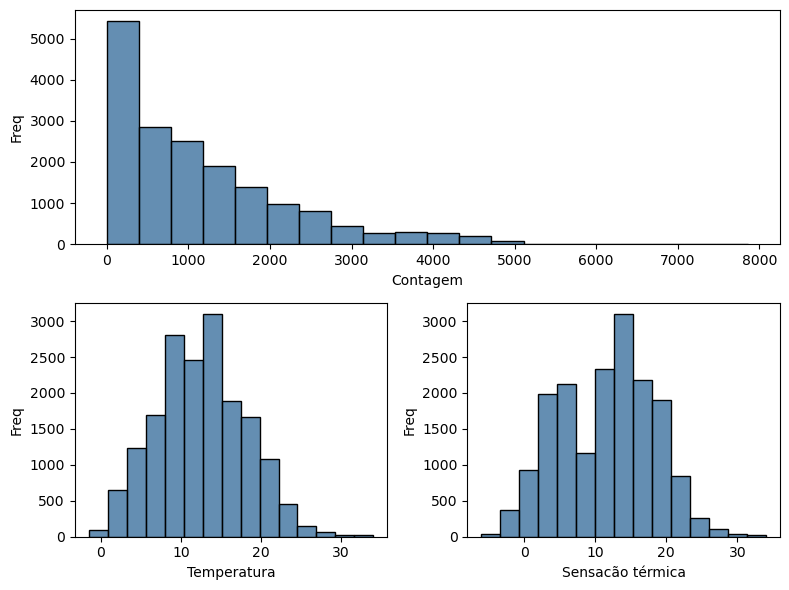

In [16]:
fig, axd = plt.subplot_mosaic(
    [["a","a"],
     ["b", "c"]],
    figsize=(8, 6)
)

sns.histplot(dados_limpo['contagem'], bins = 20, color = '#306998', ax=axd["a"])
axd["a"].set_xlabel('Contagem')
axd["a"].set_ylabel('Freq')
sns.histplot(dados_limpo['temperatura'], bins = 15, color = '#306998', ax=axd["b"])
axd["b"].set_xlabel('Temperatura')
axd["b"].set_ylabel('Freq')
sns.histplot(dados_limpo['sensacao_termica'], bins = 15, color = '#306998', ax=axd["c"])
axd["c"].set_xlabel('Sensacão térmica')
axd["c"].set_ylabel('Freq')


plt.tight_layout()
plt.show()

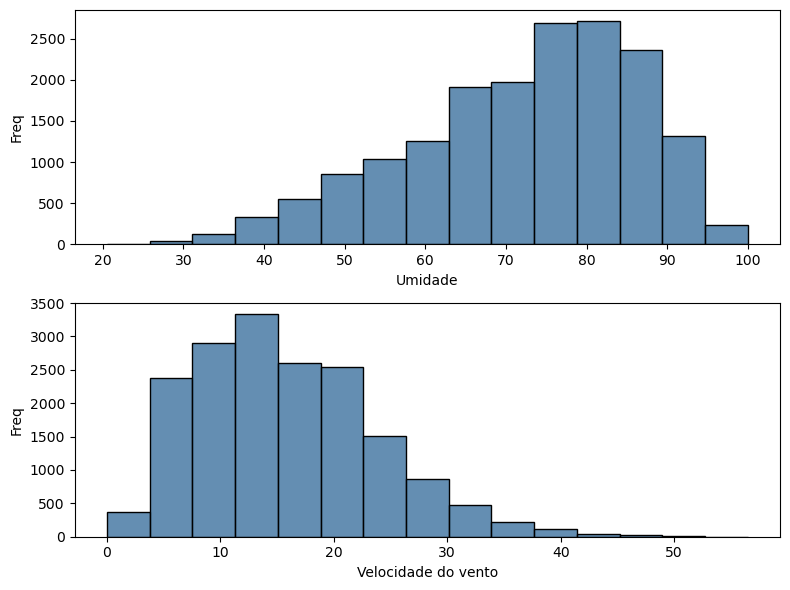

In [17]:
fig, axd = plt.subplot_mosaic(
    [["a","a"],
     ["b", "b"]],
    figsize=(8, 6)
)

sns.histplot(dados_limpo['umidade'], bins = 15, color = '#306998', ax=axd["a"])
axd["a"].set_xlabel('Umidade')
axd["a"].set_ylabel('Freq')
sns.histplot(dados_limpo['velocidade_vento'], bins = 15, color = '#306998', ax=axd["b"])
axd["b"].set_xlabel('Velocidade do vento')
axd["b"].set_ylabel('Freq')

plt.tight_layout()
plt.show()

Conforme as imagens acima, a distribuição das variáveis se dão da seguinte forma:

- As variáveis `contagem` e `velocidade_vento` possuem assimetria positiva, indicando valores positivos mais destacados na forma de onda, isto é, terá uma "cauda’ mais longa à direita.
- As variáveis `temperatura` e `sensacao_termica` possuem uma leve assimetria negativa enquanto a `umidade` é mais acentuada. Isto indica a introdução de valores negativos mais destacados na forma de onda, gerando uma "cauda" mais longa à esquerda.

### Investigando relações entre variáveis

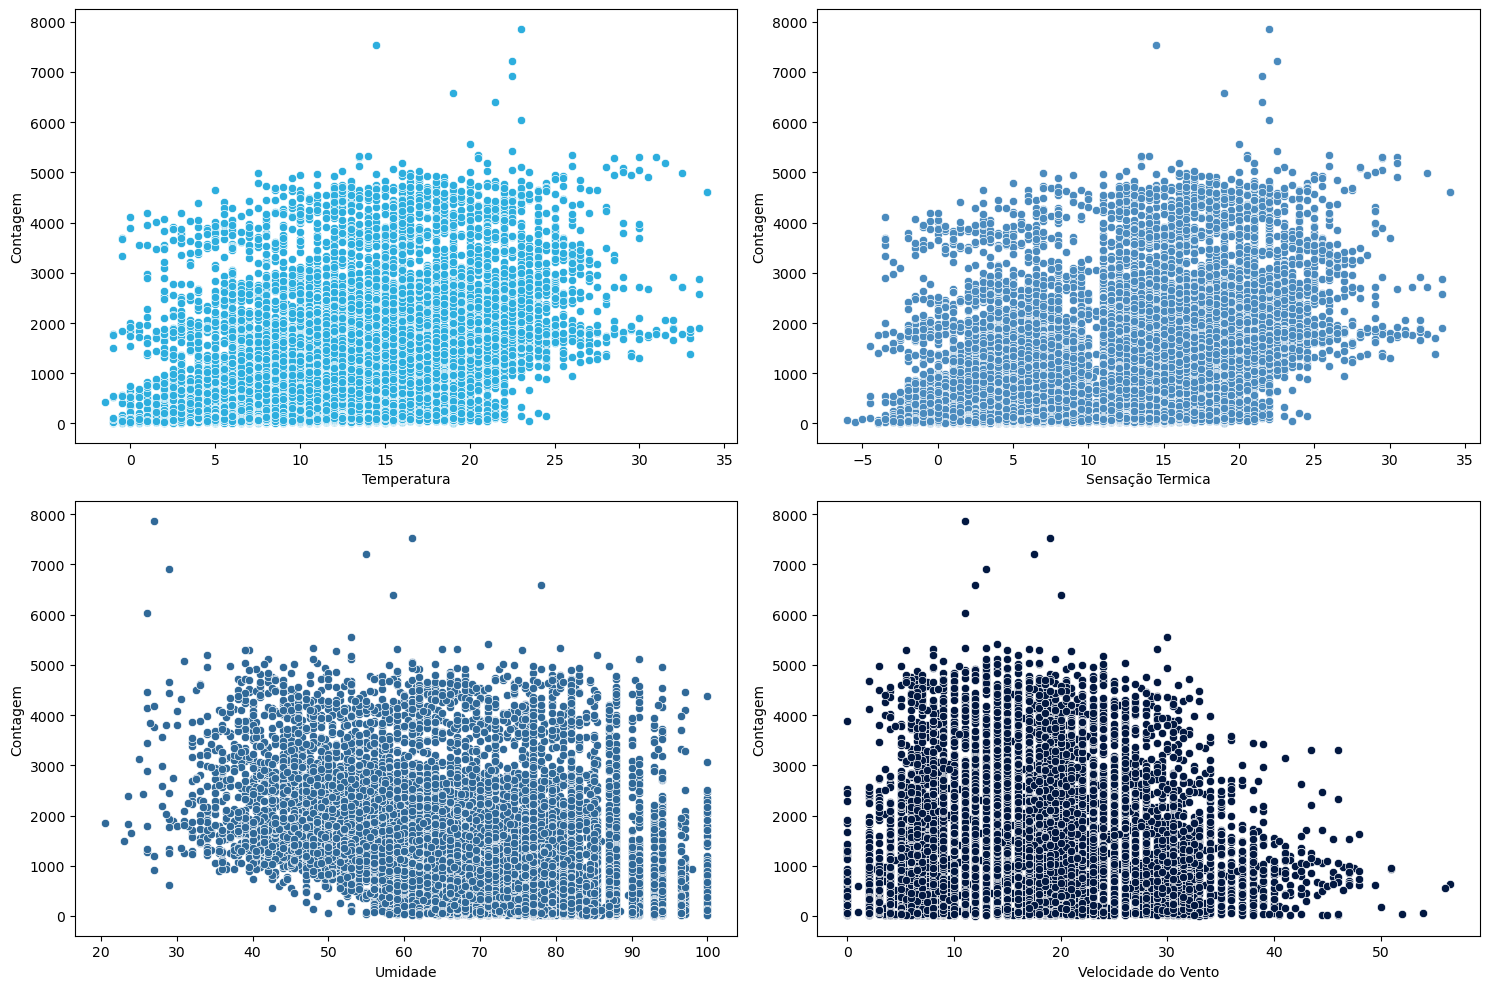

In [18]:
# Creaando uma figura e subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plotando os scatterplots
sns.scatterplot(ax=axes[0, 0], data=dados_limpo, x='temperatura', y='contagem', color='#2daede')
axes[0, 0].set_xlabel('Temperatura', fontsize = 10)
axes[0, 0].set_ylabel('Contagem', fontsize = 10)

sns.scatterplot(ax=axes[0, 1], data=dados_limpo, x='sensacao_termica', y='contagem', color='#4B8BBE')
axes[0, 1].set_xlabel('Sensação Termica', fontsize = 10)
axes[0, 1].set_ylabel('Contagem', fontsize = 10)

sns.scatterplot(ax=axes[1, 0], data=dados_limpo, x='umidade', y='contagem', color='#306998')
axes[1, 0].set_xlabel('Umidade', fontsize = 10)
axes[1, 0].set_ylabel('Contagem', fontsize = 10)

sns.scatterplot(ax=axes[1, 1], data=dados_limpo, x='velocidade_vento', y='contagem', color='#021841ff')
axes[1, 1].set_xlabel('Velocidade do Vento', fontsize = 10)
axes[1, 1].set_ylabel('Contagem', fontsize = 10)


# Ajustando layout e mostra o plot
plt.tight_layout()
plt.show()

Observando os gráficos de dispersão gerado, é notorio que não existe nenhuma relação linear forte entre as variáveis com a contagem de bicicletas alugadas. Para quantificar a associação entre elas vamos utilizar a correlação de Pearson.

### Analisando a correlação entre variáveis

In [19]:
corr = dados_limpo.corr(numeric_only = True)

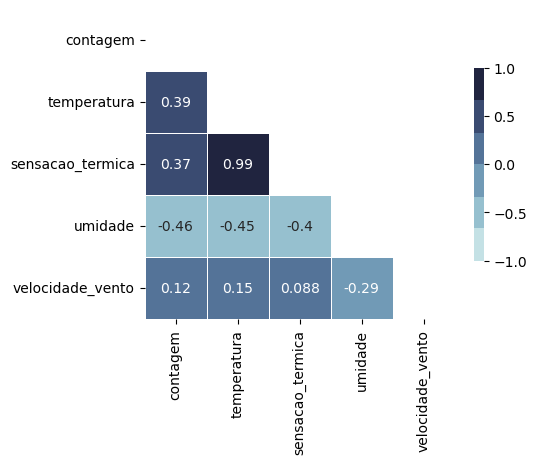

In [20]:
# Gerar uma máscara para o triângulo superior
mascara = np.zeros_like(corr, dtype=bool)
mascara[np.triu_indices_from(mascara)] = True

# Configurar a figura do matplotlib
f, ax = plt.subplots(figsize=(5, 5))

# Gerar o mapa de calor (heatmap)
cmap = sns.cubehelix_palette(rot=-.2)

sns.heatmap(corr, mask=mascara, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

# Exibir o mapa de calor (heatmap)
plt.show()

Apesar de não existir um consenso sobre o a interpretação dos valores da correlação, podemos interpretar a sua direção e a força confrome Rumsey (2023), que traz a seguinte sugestão de tamanhos de efeito:

- r = |±1| → relação linear perfeita;       
- r = |±0,70| → relação linear forte;      
- r = |±0,50| → relação linear moderada;     
- r = |±0,30| → relação linear fraca;       
- r = 0 → ausência de relação linear.    



Rumsey, D. J. (2023, 6 de fevereiro). What is r value correlation? Dummies. https://www.dummies.com/article/academics-the-arts/math/statistics/how-to-interpret-a-correlation-coefficient-r-169792/

Observa-se que as variáveis `temperatura` e `sensacao_termica` (que são altamente correlacionadas entre si) têm correlação positiva fraca a moderada com a variável `contagem`, indicando que à medida em que essas variáveis aumentam o número de bicicletas alugadas (`contagem`) tende a aumentar. Efeito contráio podemos observar para a variável `umidade`, que possui correlação linear moderada. A `velocidade_vento` possui relação linear muito fraca com a variável `contagem`. A relação entre as variáveis podem ser visualidas por meios dos **scatterplots** acima. 

Ainda, podemos interpretar a correlação através do coeficiente de determinação ($r^2$), isto é, variância que uma variável explica da outra. Desta forma, a variável `umidade` possui maior coeficiente de determinação, explicando 21,16% da variabilidade da variável `contagem`. De forma análoga, as variáveis `temperatura` e `sensacao_termica` explicam 15,21% e 13,69%, respectivamente, do número de bicicletas alugadas. Já a `velocidade_vento` explica muito pouco dessa variável, 1,44%.  

## Investigando os dados categóricos

In [21]:
dados_limpo.describe(include=['O']).T

,count,unique,top,freq
data_hora,17414,17414,2017-01-03 23:00:00,1
clima,17414,6,Céu limpo,6150
feriado,17414,2,Não,17030
fim_de_semana,17414,2,Não,12444
estacao,17414,4,Primavera,4394


Obtendo os valores únicos e suas quantidades em cada coluna:

In [22]:
for col in ['clima', 'feriado', 'fim_de_semana', 'estacao']:
    print(f'Coluna: {col}')
    print(dados_limpo[col].unique())
    print(dados_limpo[col].nunique())
    print('='*40, '\n')

Coluna: clima
['Nublado' 'Céu limpo' 'Parcialmente nublado' 'Chuva leve' 'Neve'
 'Chuva com trovoadas']
6

Coluna: feriado
['Não' 'Sim']
2

Coluna: fim_de_semana
['Sim' 'Não']
2

Coluna: estacao
['Inverno' 'Primavera' 'Verão' 'Outono']
4



Na coluna `clima` temos 6 classificações diferentes, relacionadas à condição do tempo; as colunas `feriado` e `fim_de_semana` possuem apenas as classes "Sim" e "Não"; e `estacao` é composta pelas 4 estações do ano. Por meio da moda de cada variável é possível obter o seguinte questionamento: será que as características de `clima` com "céu limpo", `feriado` e `fim_de_semana` iguais a "Não" (isto é, apenas os dias de semana) e, `estacao` do ano igual a primavera refletem maior número de aluguéis de bicicleta?

In [23]:
dados_limpo.groupby(['estacao','clima','feriado','fim_de_semana'])['contagem'].sum().to_frame().sort_values(by = 'contagem', ascending=False).head(10)

contagem
estacao   clima                feriado fim_de_semana          
Verão     Céu limpo            Não     Não             1979986
          Parcialmente nublado Não     Não             1564302
Primavera Céu limpo            Não     Não             1511439
Outono    Parcialmente nublado Não     Não             1386179
          Céu limpo            Não     Não             1175695
Inverno   Parcialmente nublado Não     Não             1068022
Primavera Parcialmente nublado Não     Não             1067695
Outono    Nublado              Não     Não             1009114
Verão     Nublado              Não     Não              789367
Inverno   Céu limpo            Não     Não              726462

Como podemos ver, esse conjunto de características não representa a condição com maior número de aluguéis, sendo ela a condição com o terceiro maior número desse serviço.

### Comparando a "contagem" dentre as diversas classes das variáveis categóricas

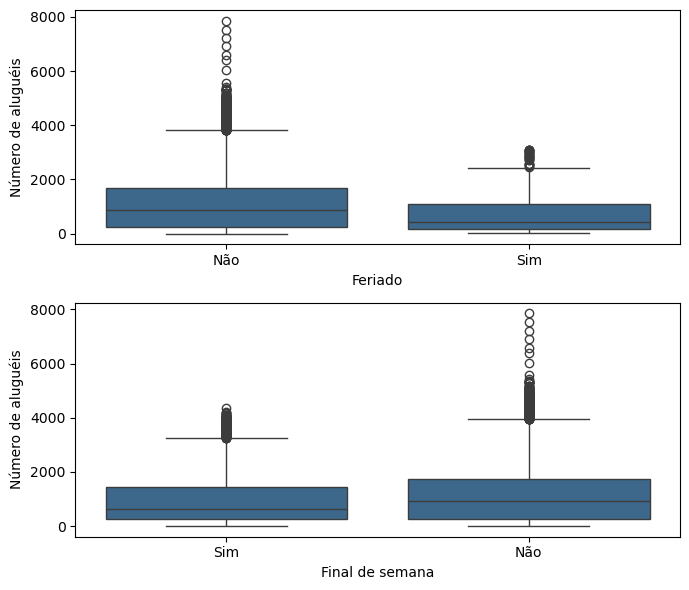

In [24]:
fig, axd = plt.subplot_mosaic(
    [["a","a"],
     ["b", "b"]],
    figsize=(7, 6)
)


sns.boxplot(x='feriado', y='contagem', data=dados_limpo, color = '#306998', ax=axd["a"])
axd["a"].set_xlabel('Feriado')
axd["a"].set_ylabel('Número de aluguéis')

sns.boxplot(x='fim_de_semana', y='contagem', data=dados_limpo, color = '#306998', ax=axd["b"])
axd["b"].set_xlabel('Final de semana')
axd["b"].set_ylabel('Número de aluguéis')


plt.tight_layout()
plt.show()

Quando avaliamos o número de aluguéis de bicicletas em dias normais versus feriados, podemos observar que esse número é maior em dias normais, isto é, em dias úteis. Conclusão semelhante tiramos ao comparar o número de aluguéis de bicicletas em dias normais versus finais de semana, concluindo que nos finais de semana a quantidade de bicicletas alugadas são menores. Abaixo vamos verificar as medianas destas duas comparações de forma numérica:

In [25]:
dados_limpo.groupby('feriado')['contagem'].median().to_frame()

,contagem
feriado,
Não,855.00
Sim,439.50


In [26]:
dados_limpo.groupby('fim_de_semana')['contagem'].median().to_frame()

,contagem
fim_de_semana,
Não,927.00
Sim,619.00


Com os dados numéricos podemos observar as medianas das classes das variáveis e verificar o distanciamento entre as distribuições das classes em cada uma das variáveis. Para a variável `feriado` o distanciamento entre as medianas das classes "Sim" e "Não" é maior do que o distanciamento dessas classes para a variável `fim_de_semana`.

### Investigando como o clima afeta a demanada

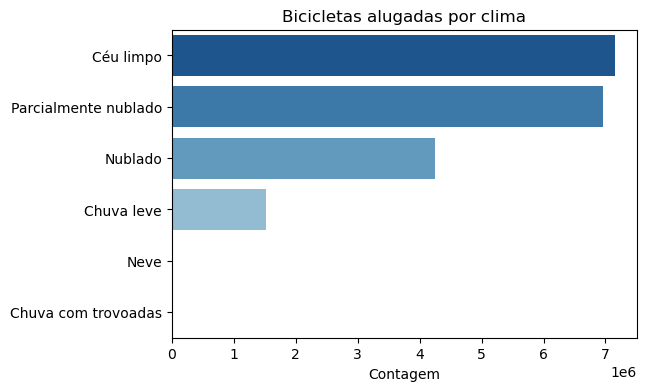

In [27]:
df_clima = dados_limpo.groupby('clima')['contagem'].sum().reset_index().sort_values(by='contagem', ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=df_clima, y='clima', x='contagem', hue='clima', palette='Blues_r', orient='h')
plt.title('Bicicletas alugadas por clima')
plt.xlabel('Contagem')
plt.ylabel('')
plt.show()

De acordo com o gráfico acima, existe uma preferência das pessoas por dias em que o sol esteja mais limpo ou parcialmente nublado.

### Investigando a distribuição por estação

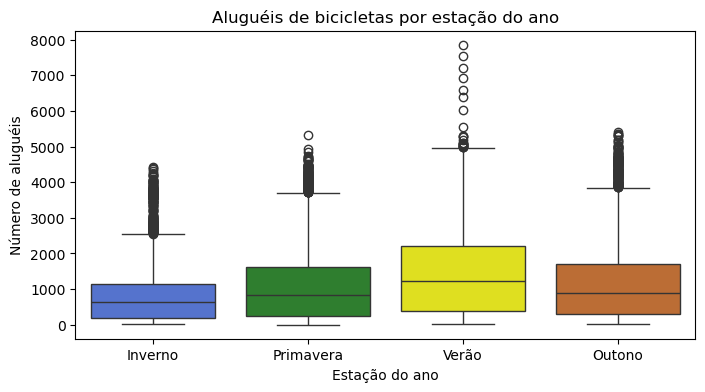

In [28]:
plt.figure(figsize=(8,4))

paleta_cores = {'Primavera': '#228B22', 
                'Verão': '#FFFF00', 
                'Outono': '#D2691E',
                'Inverno': '#4169E1'}

sns.boxplot(x='estacao', y='contagem', data=dados_limpo, hue='estacao', palette=paleta_cores)
plt.title('Aluguéis de bicicletas por estação do ano')
plt.xlabel('Estação do ano')
plt.ylabel('Número de aluguéis')
plt.show()

In [29]:
dados_limpo.groupby('estacao')['contagem'].median().reset_index()

,estacao,contagem
0,Inverno,632.00
1,Outono,898.00
2,Primavera,823.00
3,Verão,1214.00


Conforme observado, por meio dos boxplots acima, o verão é a estação com maior número de contratação de bicicletas, seguido pela primavera e outono, tendo o inverno como estação mais fraca para este tipo de negócio. 

A partir do mesmo resultado pode-se notar que a primavera e o outono tem distribuições bem parecidas e valores de mediana aproximados. Para confirmar se estas distribuições são semelhantes, estatísticamente, vamos aplicar o **Teste de Mann–Whitney U** para fazer tal verificação. 

Contudo, como ambas as estações, primavera e outono, apresentam assimetria positiva. Dados com assimetria positiva apresentam cauda alongada à direita, indicando concentração de valores extremos superiores que deslocam a média acima da mediana. Essa assimetria viola o pressuposto de simetria da normalidade, evidenciando que a função de densidade não é balanceada entre as caudas, isto constitui uma forte indicação de violação da normalidade. Para verificar se de fato os dados ferem a condição de normalidade, vamos utilizar o **teste de Shapiro–Wilk**, que tende a rejeitar a hipótese nula de normalidade quando esta condição não é atendida, reforçando a evidência empírica de que os dados não seguem uma distribuição normal. 

As hipóteses do teste de Shapiro–Wilk são:

$H_0:$ os dados seguem uma distribuição normal.\
$H_1:$ os dados não seguem uma distribuição normal.


Segue abaixo a aplicação do teste:

In [30]:
# Filtrando os dados da primavera e do outono
primavera = dados_limpo[dados_limpo['estacao'] =='Primavera']['contagem']
outono = dados_limpo[dados_limpo['estacao'] == 'Outono']['contagem']

In [31]:
# verificar a normalidade dos dados
stat_primavera, p_value_primavera = shapiro(primavera)
stat_outono, p_value_outono = shapiro(outono)

print(f'P-valor para os dados de contagem na primavera: {p_value_primavera}')
print(f'P-valor para os dados de contagem no outono: {p_value_outono}')

P-valor para os dados de contagem na primavera: 8.823648306149966e-51
P-valor para os dados de contagem no outono: 5.1023288048443525e-51


Com o resultado do teste, podemos concluir que rejeita-se a hipótese nula, devido o p-valor ser muito menor do que o nível de significância de 5%. Diante desse resultado, há evidência estatística contra a normalidade dos dados, tanto os dados de contagem na primavera quanto os dados de contagem no outono. 

Diante da rejeição da hipótese de normalidade pelo teste de Shapiro–Wilk, optou-se pela utilização do Teste de Mann–Whitney U, um método não paramétrico, para avaliar se as distribuições dos dados referentes às contagens nas estações de primavera e outono apresentam comportamento estatisticamente semelhante, sem assumir normalidade das amostras.

### **Teste de Mann–Whitney U**

O teste de Mann–Whitney U é utilizado para avaliar diferenças estatisticamente significativas entre duas amostras independentes, em cenários nos quais a premissa de normalidade não é satisfeita. Trata-se de um teste não paramétrico, baseado em postos (ranks), cuja hipótese nula estabelece que ambas as amostras são extraídas de populações com distribuições idênticas. Na prática, o teste avalia se existe diferença significativa na posição central (mediana) das distribuições, a partir da ordenação conjunta dos dados (ranks), sem depender da média ou do desvio padrão. Esse teste é especialmente adequado para dados assimétricos, com outliers ou escalas ordinais. A decisão estatística é tomada com base no p-valor, considerando um nível de significância previamente definido ($α$).       

As hipóteses do teste são:

$H_0:$ As distribuições são iguais.\
$H_1:$ As distribuições são diferentes.


In [32]:
# Aplicando o teste de Mann-Whitney
u_statistic, p_value = mannwhitneyu(primavera, outono, alternative='two-sided')

print(f'Estatística U: {u_statistic}')
print(f'P-valor: {p_value}')

Estatística U: 9044682.5
P-valor: 0.0004762100221646296


Dado um p-valor extremamente baixo (p-valor << $α$), rejeitamos a hipótese nula ao nível de significância de 5%. Isto indica que os dados de contagem na primavera tendem a ser diferente dos dados de contagem no outono.   

## Analisando os dados ao longo do tempo

In [33]:
dados_limpo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data_hora         17414 non-null  object 
 1   contagem          17414 non-null  int64  
 2   temperatura       17414 non-null  float64
 3   sensacao_termica  17414 non-null  float64
 4   umidade           17414 non-null  float64
 5   velocidade_vento  17414 non-null  float64
 6   clima             17414 non-null  object 
 7   feriado           17414 non-null  object 
 8   fim_de_semana     17414 non-null  object 
 9   estacao           17414 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 1.5+ MB


In [34]:
dados_datas = dados_limpo.copy(deep=True)
dados_datas.head()

,data_hora,contagem,temperatura,sensacao_termica,umidade,velocidade_vento,clima,feriado,fim_de_semana,estacao
0,2015-01-04 00:00:00,182,3.00,2.00,93.00,6.00,Nublado,Não,Sim,Inverno
1,2015-01-04 01:00:00,138,2.75,2.25,93.00,5.00,Céu limpo,Não,Sim,Inverno
2,2015-01-04 02:00:00,134,2.50,2.50,96.50,0.00,Céu limpo,Não,Sim,Inverno
3,2015-01-04 03:00:00,72,2.00,2.00,100.00,0.00,Céu limpo,Não,Sim,Inverno
4,2015-01-04 04:00:00,47,2.00,2.00,93.00,6.50,Céu limpo,Não,Sim,Inverno


### Convertendo datas

Para trabalhar com os dados de `data_hora` de forma adequada, precisamos convertê-lo para o tipo "datetime".

In [35]:
dados_datas['data_hora'] = pd.to_datetime(dados_datas['data_hora'])

In [36]:
dados_datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   data_hora         17414 non-null  datetime64[ns]
 1   contagem          17414 non-null  int64         
 2   temperatura       17414 non-null  float64       
 3   sensacao_termica  17414 non-null  float64       
 4   umidade           17414 non-null  float64       
 5   velocidade_vento  17414 non-null  float64       
 6   clima             17414 non-null  object        
 7   feriado           17414 non-null  object        
 8   fim_de_semana     17414 non-null  object        
 9   estacao           17414 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(4)
memory usage: 1.5+ MB


In [37]:
dados_datas['data_hora'].describe()

count                            17414
mean     2016-01-03 22:31:00.571953664
min                2015-01-04 00:00:00
25%                2015-07-04 20:15:00
50%                2016-01-03 15:30:00
75%                2016-07-04 15:45:00
max                2017-01-03 23:00:00
Name: data_hora, dtype: object

Temos dados para um período de 2 anos, indo desde janeiro de 2015 até janeiro de 2017. A seguir vamos criar novas colunas contendo os anos, meses e horas, a fim de verificar o comportamento de `contagem` ao longo dessas variáveis.

In [38]:
dados_datas['ano'] = dados_datas['data_hora'].dt.year
dados_datas['mes'] = dados_datas['data_hora'].dt.month
dados_datas['hora'] = dados_datas['data_hora'].dt.hour

Na coluna `data_hora` vamos fazer uma transformação para deixar apenas a data.

In [39]:
dados_datas['data_hora'] = dados_datas['data_hora'].dt.date
dados_datas.rename(columns = {'data_hora':'data'}, inplace = True)
dados_datas['data'] = pd.to_datetime(dados_datas['data'])

In [40]:
dados_datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17414 entries, 0 to 17413
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   data              17414 non-null  datetime64[ns]
 1   contagem          17414 non-null  int64         
 2   temperatura       17414 non-null  float64       
 3   sensacao_termica  17414 non-null  float64       
 4   umidade           17414 non-null  float64       
 5   velocidade_vento  17414 non-null  float64       
 6   clima             17414 non-null  object        
 7   feriado           17414 non-null  object        
 8   fim_de_semana     17414 non-null  object        
 9   estacao           17414 non-null  object        
 10  ano               17414 non-null  int32         
 11  mes               17414 non-null  int32         
 12  hora              17414 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(3), int64(1), object(4)
memory usage: 1.7

Tendo posse das variáveis `ano`, `mes` e `hora`, vamos fazer algumas visualizações para compreender melhor o comportamento do aluguel de bicicleta ao longo dos anos, meses, dias e horários.

### Investigando a demanda por bicicleta por horário

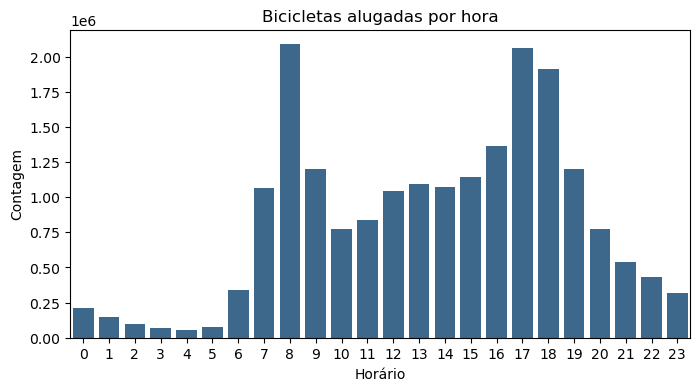

In [41]:
dados_por_hora = dados_datas.groupby('hora')['contagem'].sum().reset_index()

plt.figure(figsize=(8,4))
sns.barplot(data = dados_por_hora, x='hora', y='contagem', color = '#306998')
plt.title('Bicicletas alugadas por hora')
plt.xlabel('Horário')
plt.ylabel('Contagem')

plt.show()

De acordo com o gráfico de barras, podemos observar que existem horários de pico, sendo eles no início da manha e no final da tarde/início da noite. Possivelmente, seriam os horários onde estudantes e trabalhadores iniciam e finalizam suas rotinas diárias.

### Investigando a demanda por bicicleta por horário, no meio e final de semana

In [42]:
# Dados de aluguel de bicicleta nos diferentes horario nos dias úteis
dados_meio_de_semana = dados_datas[dados_datas['fim_de_semana'] == 'Não']
contagem_meio_de_semana = dados_meio_de_semana.groupby('hora')['contagem'].sum().reset_index()

# Dados de aluguel de bicicleta nos diferentes horario dos finais de semana
dados_fim_de_semana = dados_datas[dados_datas['fim_de_semana'] == 'Sim']
contagem_fim_de_semana = dados_fim_de_semana.groupby('hora')['contagem'].sum().reset_index()

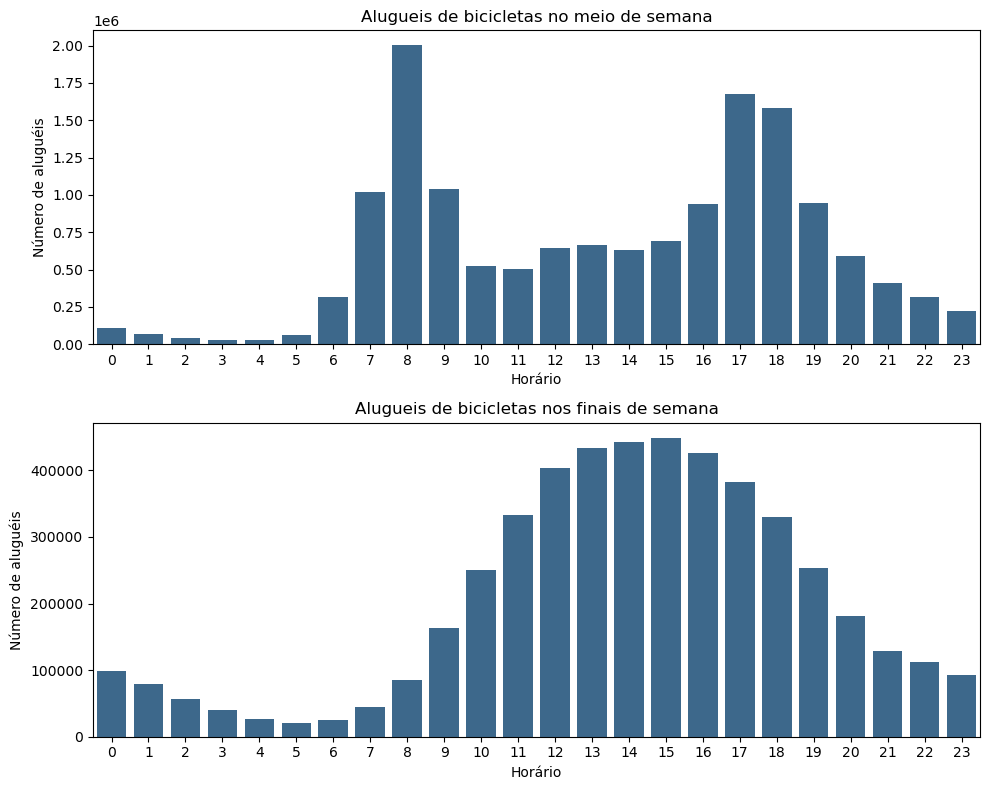

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

sns.barplot(data = contagem_meio_de_semana, x= 'hora', y = 'contagem', color = '#306998', ax=axs[0])
axs[0].title.set_text('Alugueis de bicicletas no meio de semana')
axs[0].set_xlabel('Horário')
axs[0].set_ylabel('Número de aluguéis')

sns.barplot(data = contagem_fim_de_semana, x = 'hora', y = 'contagem', color = '#306998', ax=axs[1])
axs[1].title.set_text('Alugueis de bicicletas nos finais de semana')
axs[1].set_xlabel('Horário')
axs[1].set_ylabel('Número de aluguéis')

plt.tight_layout()
plt.show()

Plotando o gráfico de aluguéis durante os dias de semana apenas confirmou os horários de pico do gráfico anterior. Quando se trata da utilização de bikes nos finais de semanas, podemos observar um crescimento da demanda em torno das 7h da manhã e atinge a demanda máxima às 15h, a partir deste momento a busca por bicicletas entra em declíneo.  

### Investigando a demanda por bicicleta ao longo dos meses

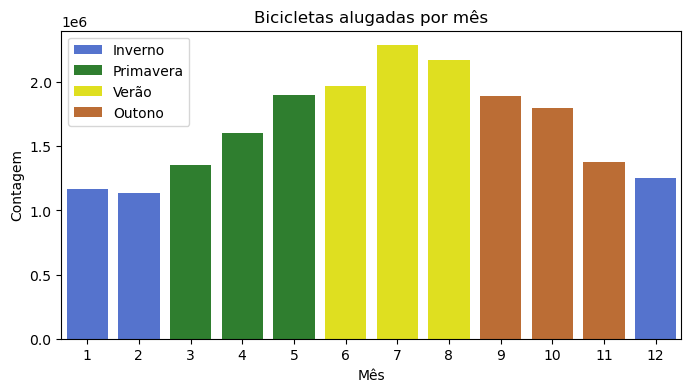

In [44]:
contagem_nos_meses = dados_datas.groupby(['estacao','mes'])['contagem'].sum().reset_index().sort_values(by = 'mes')

paleta_cores = {'Primavera': '#228B22', 
                'Verão': '#FFFF00', 
                'Outono': '#D2691E',
                'Inverno': '#4169E1'}


plt.figure(figsize=(8,4))
ax = sns.barplot(data=contagem_nos_meses, x='mes', y='contagem', hue = 'estacao', legend=True, palette= paleta_cores )
ax.legend_.set_title(None)
plt.title('Bicicletas alugadas por mês')
plt.xlabel('Mês')
plt.ylabel('Contagem')

plt.show()

Conforme visualizado anteriormente, por meio do gráfico de boxplot, é sabido que no verão é o período de maior demanda de alguéis e que o irnverno é o período em que a procura é mais baixa. Contudo, por meio do gráfico de barras é possível visualizar como a demanda por este tipo de serviço varia ao longo dos meses, tendo o mês de março (início da primavera) marcando o início do aumento de demanda até atingir o pico no mês de julho. No mês de agosto em diante entra o período de declíneo até chegar no seu nível mais baixo no mês de dezembro, onde iniciá-se o período de inverno. 

Em suma, as estações do ano podem ser descrita da seguinte forma: o inverno, é marcado como sendo o período de menor demanda (baixa constante); a primavera, é um período de demanda crescente; o verão é a estação onde se chega ao ápice e iniciá-se o momento de declíneo; e, no outono, a demanda cai até chegar o inverno novamente. 

### Investigando a demanda de bicicletas por data

In [45]:
contagem_por_data = dados_datas.groupby('data')['contagem'].sum().reset_index()

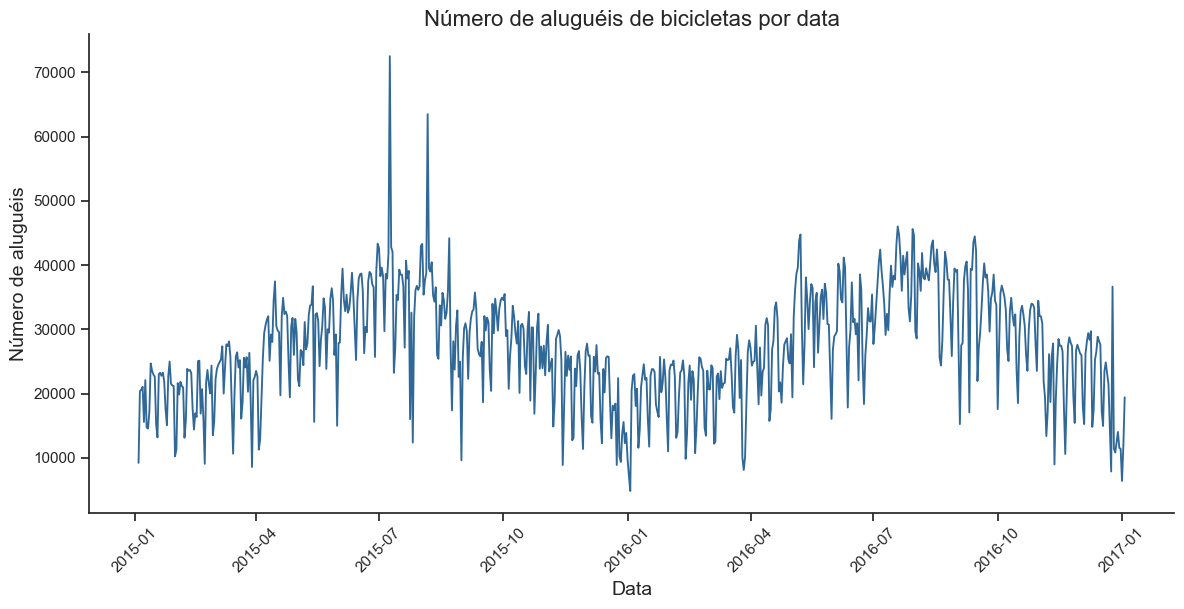

In [46]:
sns.set(style="ticks")

plt.figure(figsize=(12, 6.25))
sns.lineplot(
    data=contagem_por_data,
    x='data',
    y='contagem',
    linewidth=1.35,
    color='#306998'
)

plt.title('Número de aluguéis de bicicletas por data', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Número de aluguéis', fontsize=14)
plt.xticks(rotation=45)

sns.despine()
plt.tight_layout()
plt.show()

De acordo com o gráfico de linha acima, observa-se que os dados possuem um comportamento que se repete ao longo dos anos, exceto por dois picos de demanda entre os meses de julho e outubro de 2015. Este pico de demanda se dá devido a uma greve no metrô de Londres, o que fez com que os estudantes e trabalhadores recorressem a meios de transporte alternativos para exercerem suas atividades, ocasionando, assim, esta alta demanda no aluguéis de bicicletas. Inclusive, a Transport for London (TfL) aconselhou explicitamente que os passageiros utilizassem bicicletas ou caminhassem sempre que possível para evitar o congestionamento em outros meios de transporte.

É válido ressaltar que veículos de imprensa disponibilizaram mapas interativos para ajudar os cidadãos a encontrarem as estações de bicicletas mais próximas, visto que essa se tornou uma das opções favoritas para quem não conseguia embarcar em ônibus lotados.

Seguem alguns links de notícias publicadas na época: \
    Link 1: https://www.independent.co.uk/news/uk/home-news/tube-strike-where-s-my-nearest-boris-bike-station-10373790.html \
    Link 2: https://www.bbc.com/news/uk-england-london-33440369

# Construção do modelo com a biblioteca Prophet

**Prophet** é uma biblioteca de forecasting de séries temporais desenvolvida pelo Meta (Facebook), projetada para gerar previsões robustas em séries com tendências não lineares, sazonalidades múltiplas (diária, semanal, anual) e efeitos de feriados/eventos. 

Seu principal objetivo é permitir previsões confiáveis com mínima intervenção manual, sendo especialmente adequada para séries de negócio (demanda, receitas, tráfego, usuários ativos etc.).

O Prophet se baseia em um modelo aditivo de decomposição, ajustado via inferência bayesiana.

**Formulação Matemática do Modelo**

O Prophet modela a série temporal da seguinte forma:

$y(t) = g(t) + s(t) + h(t) + \epsilon_t$

Onde:

- $ y(t)$ é o valor observado na série temporal no tempo \( t \);
- $ g(t) $ é a componente de Tendência (trend);
- $ s(t) $ é a componente Sazonalidade (seasonality);
- $ h(t) $ é a componente de Efeitos de feriados e eventos;
- $\epsilon_t$ é o erro aleatório na previsão.

Cada componente é modelado separadamente, o que aumenta a interpretabilidade. A tendência representa o comportamento de longo prazo da série, frequentemente modelada como uma função Linear Segmentada ou Logística. A sazonalidade é modelada via séries de Fourier, o que permite capturar padrões periódicos complexos (isto é, padrões anuais, semanais e diários). A componente de feriados e eventos é tratada como variável exógena explícita (necessitam de ser explicitamente informado ao modelo), tendo como objetivo capturar efeitos temporais não periódicos que não podem ser explicados nem pela tendência nem pela sazonalidade, entrando no modelo como um termo aditivo separado. Esses efeitos não são aprendidos automaticamente: eles precisam ser explicitamente informados ao modelo.

A entrada para o Prophet é sempre um dataframe com duas colunas: `ds` e `y`. A coluna `ds` (datestamp) deve estar em um formato esperado pelo Pandas, idealmente YYYY-MM-DD. A coluna `y` deve ser numérica e representa a medida que desejamos prever. Deste modo, vamos organizar o nosso dataframe de entrada do Prophet conforme é o esperado pelo modelo.

In [47]:
dados_prophet = pd.DataFrame()

dados_prophet['ds'] = dados_datas['data']
dados_prophet['y'] = dados_datas['contagem']

dados_prophet.head()

,ds,y
0,2015-01-04,182
1,2015-01-04,138
2,2015-01-04,134
3,2015-01-04,72
4,2015-01-04,47


In [48]:
dados_prophet['ds'].value_counts()

ds
2017-01-03    24
2015-01-04    24
2015-01-05    24
2015-01-06    24
2017-01-02    24
              ..
2015-11-18    18
2015-10-13    18
2016-03-27    14
2016-09-03    12
2016-06-24     9
Name: count, Length: 730, dtype: int64

Como podemos observar, o nosso dataframe contém informações de mais de uma locação por dia e, como iremos fazer as previsões diárias, vamos fazer um agrupamento por data e ter como resultado a soma diária dos aluguéis de bicicletas para utilzarmos em nossa previsão.

In [49]:
dados_prophet = dados_prophet.groupby('ds')['y'].sum().reset_index()
dados_prophet

,ds,y
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
725,2016-12-30,11566
726,2016-12-31,11424
727,2017-01-01,6421
728,2017-01-02,11823


### Dividindo os dados em treino e teste

Agora que os dados foram devidamente ajustados, vamos para uma etapa importante que será de dividir os dados de treino e teste. Como temos poucos dados vamos usar 80% dos dados para treinar e 20% dos dados para testar o modelo

In [50]:
n =  len(dados_prophet)
percent_train = 0.85
percent_test = round(1 - percent_train, 2)

print('N Treino', math.ceil(n * percent_train))
print('N Teste', math.floor(n * percent_test))
#print('\n')
print('N Total: ', math.ceil(n * percent_train) + math.floor(n * percent_test))

N Treino 621
N Teste 109
N Total:  730


In [51]:
dados_treino = pd.DataFrame()

n_train = math.ceil(n * percent_train)

# Separando 80% dos dados para treino
dados_treino['ds'] = dados_prophet['ds'][:n_train]
dados_treino['y'] = dados_prophet['y'][:n_train]

In [52]:
dados_teste = pd.DataFrame()

# Separando 20% dos dados para teste
dados_teste['ds'] = dados_prophet['ds'][n_train:]
dados_teste['y'] = dados_prophet['y'][n_train:]

In [53]:
dados_treino.shape, dados_teste.shape

((621, 2), (109, 2))

## Gerando o modelo inicial

In [54]:
# Definindo um seed para garantir a reprodutibilidade
np.random.seed(123)

# Instanciando o modelo
modelo_prophet = Prophet(yearly_seasonality=True)

# Treinar o modelo
modelo_prophet.fit(dados_treino)

# Criando um dataframe para previsões futuras
dados_futuro = modelo_prophet.make_future_dataframe(periods=109, freq='D')

#Realizando a previsão
previsao = modelo_prophet.predict(dados_futuro)

21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing


Neste primeiro modelo foi ajustado apenas o parâmetro `yearly_seasonality = True` para incluir a sazonalidade anual ao nosso modelo. Após instanciado o modelo e feito o treinamento no nosso conjunto de dados, a função `make_future_dataframe()` fornece um dataframe adequado que se estender a um futuro específico definido pelo usuário. No nosso caso estendemos a um futuro de mesmo tamanho do nosso conjunto de dados de teste, isto é, vamos prever a quantidade de aluguéis de bibicleta para os próximos 109 dias. Por fim, o método `predict` atribuirá a cada linha futura um valor previsto, denominado `yhat`. Se você fornecer datas históricas, ele fornecerá um ajuste dentro da amostra. O objeto `previsao` aqui é um novo dataframe que inclui uma coluna `yhat` com a previsão, bem como colunas para os componentes e intervalos de incerteza. 

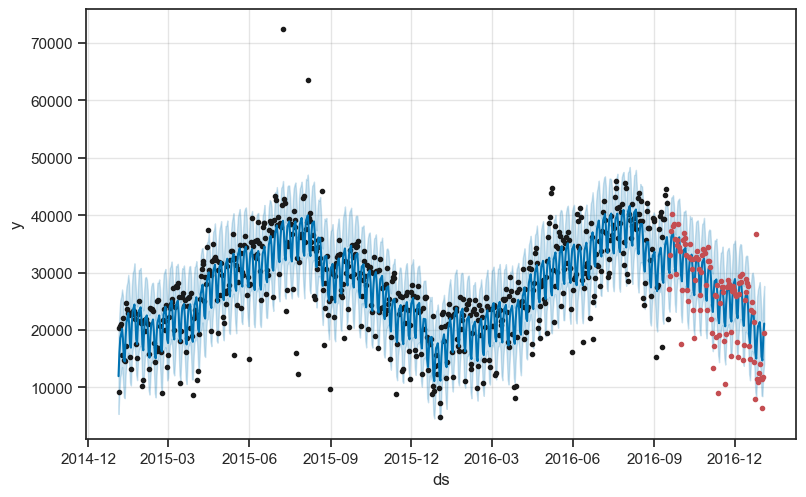

In [55]:
fig1 = modelo_prophet.plot(previsao)
fig1.set_size_inches(8, 5)

plt.plot(dados_teste['ds'], dados_teste['y'], '.r')
plt.show()

A imagem acima plota os dados da previsão. A linha de cor azul mais escura representa as previsões feitas pelo Prophet; o intervalo de confiaça, de cor azul mais claro, se estendendo en torno das previsões; e, os pontos representam os valores reais. Ainda na mesma imagem é possível verificar que os valores diários são elevados, tendo dias em que a demanda por aluguel ultrapassou a faixa de 70 mil de bicicletas. Contudo esses valores discrepantes são efeito da greve no metrô de Londres e estes dados serão considerados como valores atípicos e retirados de nossas análises futuras. 

In [56]:
previsao[['ds','yhat_lower','yhat_upper','yhat']].head()

,ds,yhat_lower,yhat_upper,yhat
0,2015-01-04,5354.07,18807.87,11933.89
1,2015-01-05,9277.13,22975.39,16026.59
2,2015-01-06,11738.51,25166.62,18569.94
3,2015-01-07,12476.49,25766.04,19292.71
4,2015-01-08,13523.93,27046.67,20173.41


Abaixo vamos unir informações geradas pelo modelo preditivo (yhat) com os valores reais contidos no conjunto de teste para verificar a capacidade do modelo de se aproximar dos valores reais.

In [57]:
dados_previsao = previsao[['ds','yhat']]
dados_comparacao = pd.merge(dados_previsao, dados_teste, on = 'ds', how = 'inner')
dados_comparacao

,ds,yhat,y
0,2016-09-17,30514.69,27182
1,2016-09-18,29884.70,29463
2,2016-09-19,33829.86,33109
3,2016-09-20,36149.16,37292
4,2016-09-21,36575.59,40267
...,...,...,...
104,2016-12-30,19236.14,11566
105,2016-12-31,15344.79,11424
106,2017-01-01,14669.58,6421
107,2017-01-02,18659.49,11823


Pela amostra gerada acima, a princípio dá a impressão que o modelo está predizendo melhor para os dados iniciais e errando mais nos dados mais distantes. 

A seguir vamos quantificar o erro médio das previsões com o  **RMSE (Root Mean Squared Error)**, que penalizando mais fortemente os erros maiores.

In [58]:
# Calculando métricas de erro
mse = round(mean_squared_error(dados_comparacao['y'], dados_comparacao['yhat']), 2)
rmse = round(np.sqrt(mse), 2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 21914349.33, RMSE: 4681.28


Para comparar a magnitude o erro gerado pelo nosso modelo, vamos adotar o RMSE relativo, pois possibilita comparar a magnitude do erro de previsão com a escala dos dados observados, oferecendo uma interpretação mais contextualizada e informativa do desempenho do modelo. Faremos uso das classes abaixo para tirar conclusões sobre o nosso modelo.

$$
\
\text{RMSE}_{\text{relativo}} = \frac{\text{RMSE}}{\bar{y}}
\
$$

<br>

| RMSE relativo | Classificação        | Interpretação                   |
| ------------- | -------------------- | ------------------------------- |
| **< 10%**     | Excelente            | Erro muito baixo                |
| **10% – 20%** | Bom                  | Boa capacidade preditiva        |
| **20% – 30%** | Moderado / Aceitável | Modelo útil, mas com limitações |
| **30% – 40%** | Alto                 | Erros relevantes                |
| **> 40%**     | Ruim                 | Baixa confiabilidade            |

Temos um **RMSE relativo** de 18,12% e, de acordo com a tabela acima, considera um modelo de boa capacidade preditiva. O RMSE relativo de 18,12% sugere que o modelo é capaz de capturar de forma consistente os principais padrões da série temporal, embora ainda sujeito a erros moderados em períodos de maior variabilidade.


Conforme observado na imagem de previsão acima, dos valores previstos gerados junto com a distribuição de pontos dos valores reais de `y`, existem diversos pontos considerados outliers, como, os pontos configurando alta demanda devido à greve do metrô de Londres. Este é um fator que reflete um aumento do nosso erro médio.

Desta forma, vamos gerar um novo modelo contendo o conjunto de dados completo e, a partir do intervalo de confiança gerado pelo Prophet, vamos definir os limites para retirada dos valores atípicos do nosso novo conjunto. As etapas desse procedimento é feito a seguir:

## Gerando o modelo com todos os dados para definir os limites de confiança

Para este fim vamos gerar o modelo apenas para obter os componentes `yhat_lower` e `yhat_upper` para o conjunto existente, não iremos prever dias futuros.

In [59]:
# Definindo um seed para garantir a reprodutibilidade
np.random.seed(123)

# Instanciando o modelo
modelo_definir_limites = Prophet()

# Treinar o modelo
modelo_definir_limites.fit(dados_prophet)

# Criando um dataframe para previsões futuras
dados_futuro_limites = modelo_definir_limites.make_future_dataframe(periods=0, freq='D')

#Realizando a previsão
previsao_definir_limites = modelo_definir_limites.predict(dados_futuro_limites)

21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing


In [60]:
dados_sem_outliers = dados_prophet[(dados_prophet['y'] > (previsao_definir_limites['yhat_lower'] * 0.9)) & (dados_prophet['y'] < (previsao_definir_limites['yhat_upper'] * 1.1))]
dados_sem_outliers.reset_index(drop=True, inplace=True)
dados_sem_outliers

,ds,y
0,2015-01-04,9234
1,2015-01-05,20372
2,2015-01-06,20613
3,2015-01-07,21064
4,2015-01-08,15601
...,...,...
677,2016-12-30,11566
678,2016-12-31,11424
679,2017-01-01,6421
680,2017-01-02,11823


## Dividir novamente o conjunto em treino e teste para trabalahar com dados sem outliers

Como houve redução dos dados disponíveis, vamos priorizar que o modelo tenha acesso a mais dados históricos e utilizar 90% dos dados para treinamento. Apesar de representar 10% do total de observações, o conjunto de teste cobre um período temporal superior ao horizonte de previsão, garantindo cobertura temporal suficiente para avaliar a capacidade preditiva do modelo em condições reais de uso. **A partir deste momento vamos fazer previsões limitadas ao tamanho do nosso conjunto de dados de teste.**

In [61]:
n_sem_outliers =  len(dados_sem_outliers)
percent_train = 0.90
percent_test = round(1 - percent_train, 2)


print('N Treino', math.ceil(n_sem_outliers * percent_train))
print('N Teste', math.floor(n_sem_outliers * percent_test))
print('N Total: ', math.ceil(n_sem_outliers * percent_train) + math.floor(n_sem_outliers * percent_test))

N Treino 614
N Teste 68
N Total:  682


In [62]:
# Separar dados de treinamento
df_treino_sem_outliers = pd.DataFrame()

n_train_sem_out = math.ceil(n_sem_outliers * percent_train)

df_treino_sem_outliers['ds'] = dados_sem_outliers['ds'][:n_train_sem_out]
df_treino_sem_outliers['y'] = dados_sem_outliers['y'][:n_train_sem_out]


# Separar dados de teste
df_teste_sem_outliers = pd.DataFrame()

df_teste_sem_outliers['ds'] = dados_sem_outliers['ds'][n_train_sem_out:]
df_teste_sem_outliers['y'] = dados_sem_outliers['y'][n_train_sem_out:]

In [63]:
df_treino_sem_outliers.shape, df_teste_sem_outliers.shape

((614, 2), (68, 2))

## Gerar modelo após a retirada de outliers do conjunto de dados

In [64]:
# Definindo um seed para garantir a reprodutibilidade
np.random.seed(123)

# Instanciando o modelo
modelo_prophet_sem_outliers = Prophet(yearly_seasonality=True)

# Treinar o modelo
modelo_prophet_sem_outliers.fit(df_treino_sem_outliers)

# Criando um dataframe para previsões futuras
df_futuro_sem_outliers = modelo_prophet_sem_outliers.make_future_dataframe(periods=68, freq='D')

#Realizando a previsão
previsao_sem_outliers = modelo_prophet_sem_outliers.predict(df_futuro_sem_outliers)

21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing


Abaixo pode ser visto os valores previsto pelo modelo, conforme segue a linha azul mais escura, e os pontos dispersos representando os valores reais de `y`.

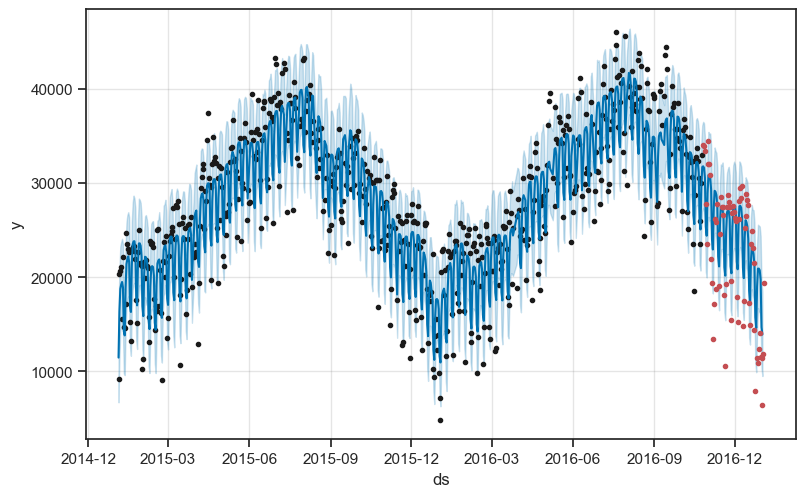

In [65]:
fig_sem_outliers = modelo_prophet_sem_outliers.plot(previsao_sem_outliers)
fig_sem_outliers.set_size_inches(8, 5)

plt.plot(df_teste_sem_outliers['ds'], df_teste_sem_outliers['y'], '.r')
plt.show()

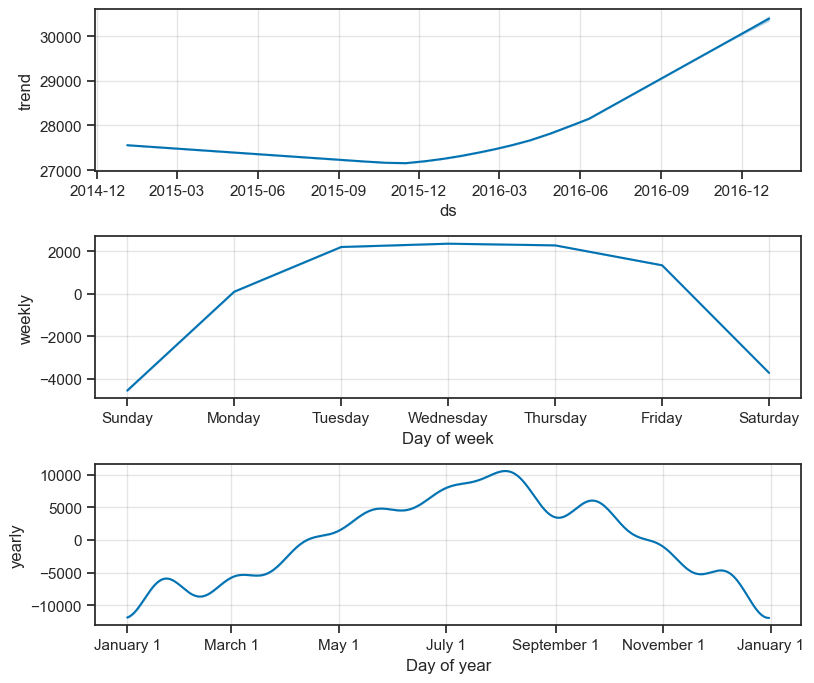

In [66]:
fig = plot_components(
    modelo_prophet_sem_outliers, 
    previsao_sem_outliers
)

fig.set_size_inches(8.3, 7)
plt.tight_layout()
plt.show()

Na figura acima é ilustrado os componentes da previsão. No gráfico superior temos a tendência representando o comportamento de longo prazo da série temporal. Ela mostra que em janeiro do ano seguinte a série terá uma tendência de crescimento. O gráfico do meio traz o componente yearly, que representa a sazonalidade anual. Conforme foi visto em nossas análises anteriores (no gráfico de "Bicicletas alugadas por mês"), o gráfico de sazonalidade anual confirma o mesmo comportamento identificado anteriormente, onde mostra que o ano inicia no período de baixa demanda, porém, em crescimento, atinge o pico próximo a julho, e entra novamente em período de queda até janeiro. Desta forma os ciclos se repetem. O componente weekly representa a sazonalidade semanal, e nos mostra comportamente semelhante ao que também já foi visto anteriormente, de que a demanda é maior durante os dias da semana e, menor, nos finais de semana.

Abaixo segue o dataframe que iremos unir as informações dos valores previstos e dos valores reais de `y`, para então obter a métrica de erro do para este modelo. 

In [67]:
df_previsao_sem_outliers = previsao_sem_outliers[['ds','yhat']]
df_comparacao_sem_outliers = pd.merge(df_previsao_sem_outliers, df_teste_sem_outliers, on='ds', how='inner')
df_comparacao_sem_outliers

,ds,yhat,y
0,2016-10-26,31775.26,34010
1,2016-10-27,31606.40,33888
2,2016-10-28,30563.74,33420
3,2016-10-29,25374.97,27785
4,2016-10-30,24402.76,23535
...,...,...,...
61,2016-12-28,20908.84,12428
62,2016-12-29,20726.66,14052
63,2016-12-30,19741.56,11566
64,2016-12-31,14684.04,11424


In [68]:
# Calculando métricas de erro
mse = round(mean_squared_error(df_comparacao_sem_outliers['y'], df_comparacao_sem_outliers['yhat']), 2)
rmse = round(np.sqrt(mse), 2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 19664232.03, RMSE: 4434.44


Após retirar os valores discrepantes alcançamos uma redução significativa do RMSE, agora estamos errando $246.84$ pontos a menos quando comparado com o modelo anterior. 

### Ajustar parâmetros do modelo

O Prophet inclui funcionalidades para a validação cruzada de séries temporais, permitindo medir o erro de previsão usando dados históricos. Isso é feito selecionando pontos de corte no histórico e, para cada um deles, ajustando o modelo usando apenas os dados até esse ponto de corte. Podemos então comparar os valores previstos com os valores reais.

A validação cruzada abaixo será realizada utilizando janelas temporais deslizantes, o que permite o Prophet avaliar o desempenho do modelo em múltiplos cenários fora da amostra. O processo é empregado como critério para comparação em diferentes configurações de hiperparâmetros, uma vez que a biblioteca não realiza seleção automática do melhor modelo. Abaixo segue a implementação da validação cruzada, junto com as métricas para obter a configuração dos melhores parâmetros ajustados para o nosso dataset.

In [69]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality' : [True, False]
}

# Gerar todas as combinações de parâmetros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Armazenar os RMSEs para cada conjunto de parâmetros aqui

# Usar validação cruzada para avaliar todos os parâmetros
for params in all_params:
    m = Prophet(**params).fit(df_treino_sem_outliers)  # Ajustar o modelo com os parâmetros fornecidos
    df_cv = cross_validation(m, initial='365.25 days', period='30 days', horizon='60 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Encontrar os melhores parâmetros
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

21:27:48 - cmdstanpy - INFO - Chain [1] start processing
21:27:48 - cmdstanpy - INFO - Chain [1] done processing
21:27:50 - cmdstanpy - INFO - Chain [1] start processing
21:27:50 - cmdstanpy - INFO - Chain [1] done processing
21:27:51 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:55 - cmdstanpy - INFO - Chain [1] start processing
21:27:55 - cmdstanpy - INFO - Chain [1] done processing
21:27:57 - cmdstanpy - INFO - Chain [1] start processing
21:27:57 - cmdstanpy - INFO - Chain [1] done processing
21:27:59 - cmdstanpy - INFO - Chain [1] start processing
21:27:59 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:02 - cmdstanpy - INFO - Chain [1] done processing
21:28:03 - cmdstanpy - INFO - Chain [1] start processing
21:28:03 - cmdstanpy - INFO - Chain [1]

No trecho acima foi realizado a validação cruzada temporal do modelo Prophet por meio de uma busca exaustiva em grade (grid search), avaliando diferentes configurações de hiperparâmetros relacionados à flexibilidade da tendência (changepoint_prior_scale) e à regularização da sazonalidade (seasonality_prior_scale), bem como a inclusão da sazonalidade anual. O desempenho de cada configuração foi mensurado com base no RMSE obtido em janelas temporais fora da amostra, permitindo a seleção do conjunto de parâmetros que apresenta melhor capacidade de generalização para previsões futuras.

In [70]:
import warnings

warnings.filterwarnings("ignore",
                        category=FutureWarning,
                        module="prophet")

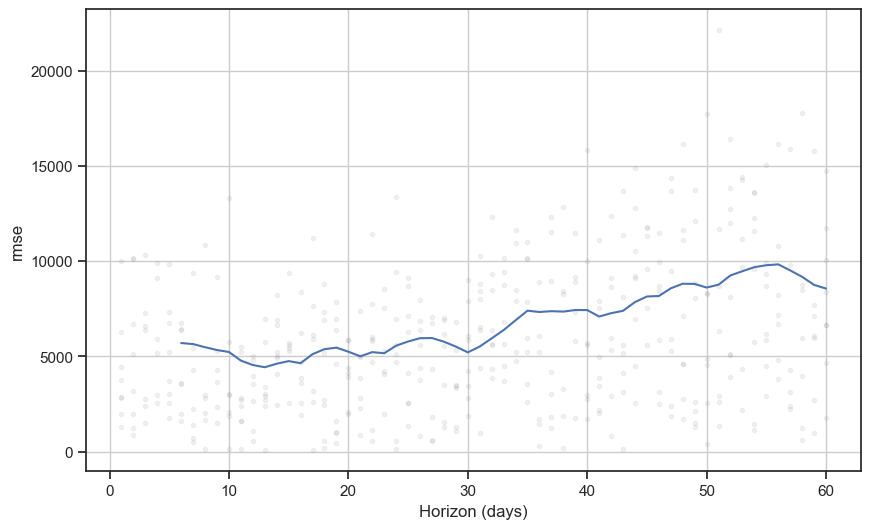

In [71]:
plot_cross_validation_metric(df_cv,metric='rmse');

Por meio da função `plot_crossvalidation_metric()` podemos visualizar métricas de desempenho de validação cruzada ao longo do horizonte de previsão (horizon). Através da imagem, podemos ver os pontos do RMSE para cada previsão em um horizonte específico e, a linha azul, sendo a média móvel sobre os valores do RMSE.

É notado que até o horizonte de 30 dias o modelo mantem o RMSE em torno de 5000 e, a medida que o horizonte de previsão aumenta, este erro também tende a aumentar. O RMSE da validação cruzada é uma estimativa conservadora do erro, pois, na validação cruzada os modelos são treinados com subconjuntos dos dados de treinamento, aumentando o grau de incerteza. Porém, o nosso objetivo com a validação cruzada não foi o de produzir o menor RMSE possível,
mas selecionar parâmetros que generalizam melhor a equação do nosso modelo. 

In [72]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'yearly_seasonality': True}


Obtidos os parâmetros com melhor generalização na validação cruzada, vamos utilizá-los em nosso conjunto de treinamento (completo) e avaliar a sua capacidade de generalização. A melhor configuração de parâmetros foram:

- changepoint_prior_scale = 0.01;
- seasonality_prior_scale = 10.0;
- yearly_seasonality = True.
    

In [73]:
# Definindo um seed para garantir a reprodutibilidade
np.random.seed(123)

# Instanciando o modelo
modelo_prophet_sem_outlier_cv = Prophet(changepoint_prior_scale = 0.01, seasonality_prior_scale = 10, yearly_seasonality=True)

# Treinar o modelo
modelo_prophet_sem_outlier_cv.fit(df_treino_sem_outliers)

# Criando um dataframe para previsões futuras
dados_futuro_sem_outlier_cv = modelo_prophet_sem_outlier_cv.make_future_dataframe(periods=64, freq='D')

#Realizando a previsão
previsao_sem_outlier_cv = modelo_prophet_sem_outlier_cv.predict(dados_futuro_sem_outlier_cv)

21:28:39 - cmdstanpy - INFO - Chain [1] start processing
21:28:39 - cmdstanpy - INFO - Chain [1] done processing


In [74]:
df_previsao_sem_outliers_cv = previsao_sem_outlier_cv[['ds','yhat']]
df_comparacao_sem_outliers_cv = pd.merge(df_previsao_sem_outliers_cv, df_teste_sem_outliers, on='ds', how='inner')

In [75]:
# Calculando métricas de erro
mse = round(mean_squared_error(df_comparacao_sem_outliers_cv['y'], df_comparacao_sem_outliers_cv['yhat']), 2)
rmse = round(np.sqrt(mse), 2)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 15668809.34, RMSE: 3958.38


Durante a validação cruzada, o modelo apresentou valores de RMSE superiores em relação ao ajuste final, o que é esperado, uma vez que cada iteração utiliza subconjuntos reduzidos do histórico e avalia o desempenho estritamente fora da amostra. Após a seleção dos melhores hiperparâmetros, o reajuste do modelo com todo o conjunto de treino proporcionou uma estimativa mais robusta da tendência e das sazonalidades, resultando em menor erro de ajuste.

Abaixo segue a plotagem dos dados de previsão do modelo, em azul mais escuro, e os pontos representando os valores reais de `y`.

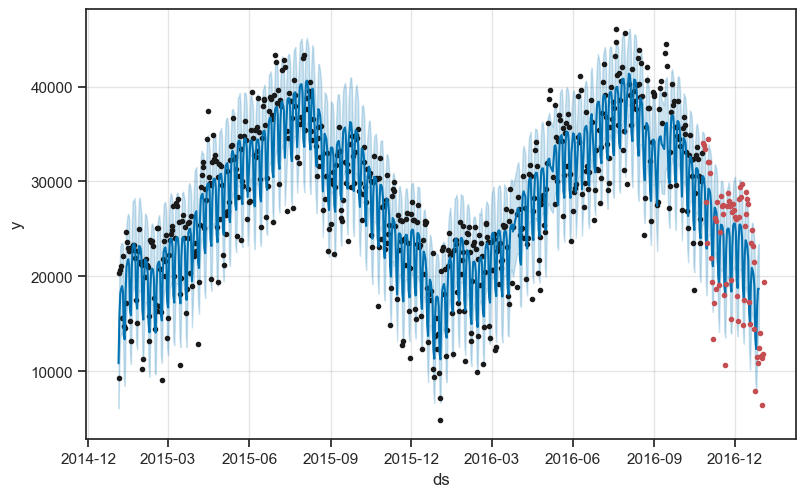

In [76]:
fig_sem_outliers_cv = modelo_prophet_sem_outlier_cv.plot(previsao_sem_outlier_cv)
fig_sem_outliers_cv.set_size_inches(8, 5)

plt.plot(df_teste_sem_outliers['ds'], df_teste_sem_outliers['y'], '.r')
plt.show()

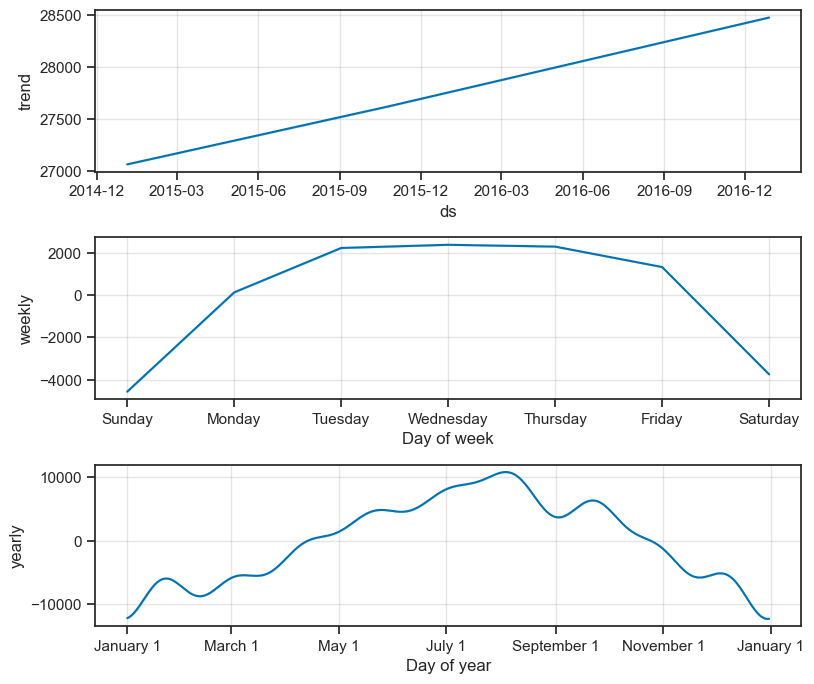

In [77]:
fig = plot_components(
    modelo_prophet_sem_outlier_cv, 
    previsao_sem_outlier_cv
)

fig.set_size_inches(8.3, 7)
plt.tight_layout()
plt.show()

Acima segue a ilustração dos dos componetes de tendência, sazonalidade anual e semanal. O comportamento capiturado pelo modelo é semelhante ao comportamente capiturado anteriormente.

Com relação ao RMSE relativo, este modelo alcançou uma redução para 17,53%, representando um redução na magnitude do erro de previsão. Este modelo apresentou uma redução no erro de previsão de 476,06 unidades quando comparado com o modelo anterior e, desta forma, possui melhor capacidade de generalização. 

# Conclusão


Este projeto demonstrou, de forma prática e estruturada, como técnicas de Análise Exploratória de Dados (EDA) e modelagem preditiva podem ser integradas para compreender padrões temporais e gerar previsões confiáveis de demanda.

Na etapa exploratória, foi possível identificar comportamentos sazonais bem definidos, tendências de longo prazo e variações associadas a fatores temporais, como ciclos anuais e mensais. A análise estatística e visual evidenciou que a série temporal apresenta estrutura não aleatória, com padrões recorrentes que justificam o uso de modelos específicos para séries temporais. Esse entendimento prévio foi fundamental para orientar as decisões de modelagem e evitar abordagens inadequadas.

A modelagem preditiva, conduzida com o Prophet, mostrou-se eficaz ao capturar simultaneamente tendência, sazonalidade e efeitos de calendário, características centrais do problema analisado. A utilização de validação cruzada temporal permitiu avaliar o desempenho do modelo de forma realista, respeitando a ordem temporal dos dados e reduzindo riscos de overfitting. As métricas obtidas indicam um modelo consistente, com capacidade de generalização adequada para previsões de curto e médio prazo.

De forma geral, os resultados obtidos mostram que a abordagem adotada é robusta e aplicável em cenários reais, especialmente em contextos de planejamento operacional e tomada de decisão baseada em dados. O projeto reforça a importância de uma EDA bem conduzida como base para modelos preditivos mais confiáveis e demonstra como modelos de séries temporais podem gerar valor ao transformar dados históricos em insights acionáveis.